# Transfer Learning Part 1: Feature Extraction

Transfer leanring is leveraging a working model's existing architecture and learned patterns for our own problem.



In [ ]:
# import os
# !rm -rf /content/tensorflow_hub

In [ ]:
# Are we using a GPU?
!nvidia-smi

Fri Jan  6 03:37:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

## Downloading and Visualizing

In [2]:
# get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# Unzip
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-01-08 18:32:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 173.194.202.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   165MB/s    in 1.0s    

2023-01-08 18:32:49 (165 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in our folder
import os

# Walk through 10 percent data directory and list number of file
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 10 director

## Create data loaders (preparing the data)

We'll usea 'ImageDataGenerator' class to load our images in batches

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = '/content/10_food_classes_10_percent/train/'
test_dir = '/content/10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical',)

print('Testing images:')
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                             target_size=IMAGE_SHAPE,
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical')

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:
* Trackign experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# Create TensorBoard callback (functionize because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name+'/'+experiment_name+'/'+datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving Tensorboard log files to: {log_dir}')

  return tensorboard_callback

## Create models using TensorFlow Hub

Pre-trained models: https://www.tensorflow.org/hub

Browsing the above link , we found below models,

https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

In [6]:
# Let's compare the following two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'
efficient_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [7]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers 

In [8]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url,num_classes=10):
  '''
  Returns:
  An uncompiled Keras Sequenctial model with model_url as feature extractor 
  layer and Dense outpul layer with num_classes output neurons.
  '''

  # Download the pretrained model and save it as Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # feaze the already learned patterns
  
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation='softmax',name='output_layer')
  ])

  return model

### Creating ResNet TensorFlow Hub Feature Extraction model

In [9]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [10]:
# Compile the ResNet model
resnet_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [11]:
# Fit the model
history_resnet = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks = [create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                           experiment_name='resnet50V2')])



Saving Tensorboard log files to: tensorflow_hub/resnet50V2/20230108-183303
Epoch 1/5
24/24 [==============================] - 30s 766ms/step - loss: 1.9532 - accuracy: 0.3307 - val_loss: 1.2601 - val_accuracy: 0.5840
Epoch 2/5
24/24 [==============================] - 17s 729ms/step - loss: 0.9372 - accuracy: 0.7213 - val_loss: 0.8462 - val_accuracy: 0.7216
Epoch 3/5
24/24 [==============================] - 16s 700ms/step - loss: 0.6464 - accuracy: 0.8053 - val_loss: 0.7439 - val_accuracy: 0.7608
Epoch 4/5
24/24 [==============================] - 16s 690ms/step - loss: 0.4771 - accuracy: 0.8693 - val_loss: 0.6876 - val_accuracy: 0.7764
Epoch 5/5
24/24 [==============================] - 16s 696ms/step - loss: 0.3816 - accuracy: 0.9040 - val_loss: 0.6650 - val_accuracy: 0.7784


In [12]:
# Let's create a function to plot the loss curves
import matplotlib.pyplot as plt

# Plot the validation and training curves

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.figure()
  plt.plot(epochs,loss,label='Training_loss')
  plt.plot(epochs,val_loss,label='Val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot Accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label='Training_accuracy')
  plt.plot(epochs,val_accuracy,label='Val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

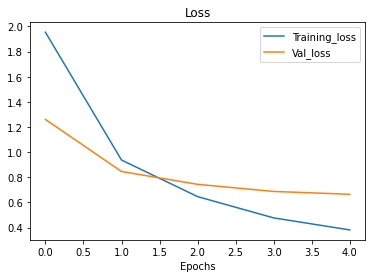

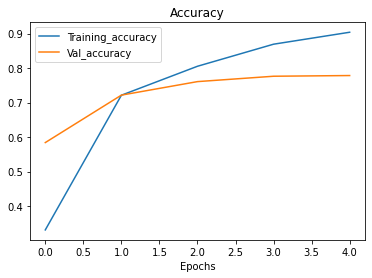

In [13]:
plot_loss_curves(history_resnet)

### Creating EfficientNetB0 TensorFlow Hub Feature Extraction model

In [14]:
# Create EfficienetB0 feature extraction model
efficientnet_model = create_model(model_url=efficient_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile the model
efficientnet_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

# Fit the model
history_efficientnet = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data = test_data_10_percent,
                                              validation_steps = len(test_data_10_percent),
                                              callbacks = [create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                        experiment_name='efficientnetB0')]
                                              )

Saving Tensorboard log files to: tensorflow_hub/efficientnetB0/20230108-183450
Epoch 1/5
24/24 [==============================] - 25s 725ms/step - loss: 1.8007 - accuracy: 0.4827 - val_loss: 1.2732 - val_accuracy: 0.7448
Epoch 2/5
24/24 [==============================] - 15s 654ms/step - loss: 1.0474 - accuracy: 0.7853 - val_loss: 0.8496 - val_accuracy: 0.8280
Epoch 3/5
24/24 [==============================] - 15s 663ms/step - loss: 0.7402 - accuracy: 0.8387 - val_loss: 0.6832 - val_accuracy: 0.8464
Epoch 4/5
24/24 [==============================] - 15s 651ms/step - loss: 0.5971 - accuracy: 0.8733 - val_loss: 0.6005 - val_accuracy: 0.8568
Epoch 5/5
24/24 [==============================] - 15s 648ms/step - loss: 0.5056 - accuracy: 0.8947 - val_loss: 0.5491 - val_accuracy: 0.8648


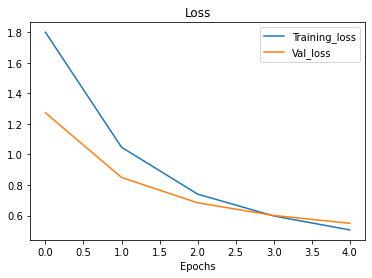

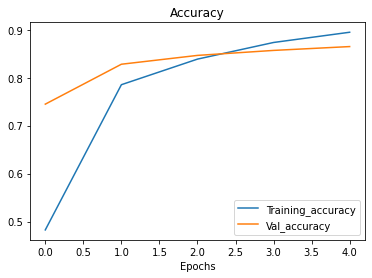

In [15]:
plot_loss_curves(history_efficientnet)

In [16]:
# How many layers we have
efficientnet_model.layers

In [17]:
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **'As is' transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own
* **'Feature extraction' transfer learning** - Use the prelearned patterns of an existing model(e.g EfficienNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g 1000 classes => 10 classes food)
* **'Fine-tuning' transfer learning** - use the prelearned patterns of an existing model and 'fine-tune' many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> 🔑 **Note:** When you upload things to TensorBoard.dev, the experiments are public. If your experiments are private, do not upload.

In [18]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name 'EfficientNetB0 vs. ResNet50V2' \
  --description 'Comparing two diffrent TF....' \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=TdsfGc9AL8J2GmQumB89CPJcF7f6oT&prompt=consent&access_type=off

Our model details are uploaded here: 
https://tensorboard.dev/experiment/AzdgoFyZR12FLBtPfNIOng/#scalars

In [21]:
! tensorboard dev list

https://tensorboard.dev/experiment/AzdgoFyZR12FLBtPfNIOng/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two diffrent TF....
	Id                   AzdgoFyZR12FLBtPfNIOng
	Created              2023-01-08 18:38:43 (12 minutes ago)
	Updated              2023-01-08 18:38:45 (12 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918466
Total: 1 experiment(s)


In [23]:
# Delete an experiment
# !tensorboard dev delete --experiment_id AzdgoFyZR12FLBtPfNIOng

In [24]:
# Confirm the deletion by re-checking what experiments you have left
!tensorbord dev list

/bin/bash: tensorbord: command not found
